In [1]:
import pandas as pd
from pathlib import Path

In [2]:
hek1='/home/hsher/scratch/circ_nextera/output/edits/circseq-bm-rar11-nxt.final_edit_score.tsv'
hek1_df = pd.read_csv(hek1, index_col = 0, sep = '\t')

hek2='/home/hsher/scratch/circ_nextera_iter2/output/edits/HEK_rar11.final_edit_score.tsv'
hek2_df = pd.read_csv(hek2, index_col = 0, sep = '\t')

snps = set(hek1_df['pos_id']).union(hek2_df['pos_id'])

In [3]:
indir = Path('/home/hsher/scratch/circ_nextera_iter13/output/edits')
edits = {}
for f in list(indir.glob('*.final_edit_score.tsv')):
    df = pd.read_csv(f, index_col= 0, sep = '\t')
    
    edits[f.name.split('.')[0]]=df

In [4]:
both_detected = set(edits['YTHDF2_STAMP']['circ_id']).intersection(
    set(edits['APOBEC1only']['circ_id'])).intersection(edits['RBM15_STAMP']['circ_id'])

In [5]:
len(both_detected)

6107

In [6]:
edits_filtered = {}
for name in edits:
    df = edits[name]
    edits_filtered[name]=df.loc[(df['circ_id'].isin(both_detected))&(~df['pos_id'].isin(snps))]

Text(0.5, 0.98, 'tested edits')

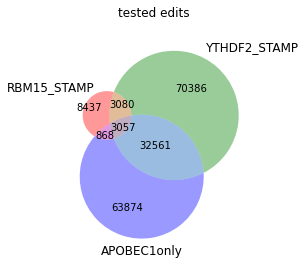

In [7]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
venn3([set(n.loc[n['circ_id'].isin(both_detected),'pos_id']) for n in edits.values()],
      set_labels = list(edits.keys())
     )
plt.suptitle('tested edits')

Text(0.5, 0.98, 'enriched edits')

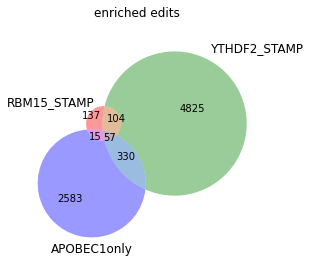

In [8]:
fdr_thres = 0.2
venn3([set(n.loc[(n['circ_id'].isin(both_detected))&(n['FDR']<fdr_thres),'pos_id']) for n in edits.values()],
      set_labels = list(edits.keys())
     )
plt.suptitle('enriched edits')

In [9]:
transcirc = pd.read_csv('transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [10]:
for df in edits.values():
    df['m6A']=df['circ_id'].map(transcirc.set_index('circ_id')['m6A'].replace({1:True, 0:False}))
    df.dropna(inplace = True)

In [18]:
cnts_per_circ = {}
for rbp in edits:
    df = edits_filtered[rbp]
    df['is_enriched']=df['FDR']<fdr_thres
    cnts_per_circ[rbp]=pd.pivot_table(df, index = 'circ_id', columns = 'is_enriched', aggfunc = 'size').fillna(0)
    #cnts_per_circ[rbp]['m6A'] = transcirc.set_index('circ_id')['m6A'].replace({1:True, 0:False})

/scratch/hsher/33834097.tscc-mgr7.local/ipykernel_14529/1377756368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_enriched']=df['FDR']<fdr_thres
/scratch/hsher/33834097.tscc-mgr7.local/ipykernel_14529/1377756368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_enriched']=df['FDR']<fdr_thres
/scratch/hsher/33834097.tscc-mgr7.local/ipykernel_14529/1377756368.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [19]:
# from sklearn.metrics import precision_recall_curve
# for key in cnts_per_circ:
#     df = cnts_per_circ[key]
#     df = df.loc[df[True]+df[False]>10]
#     from sklearn.metrics import precision_recall_curve
#     precision, recall, thresholds = precision_recall_curve(
#         df['m6A'].astype(int), df[True]/(df[False]+df[True]))
#     plt.plot(recall, precision, label = key)
# plt.legend()

# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.title('classify by % edits is significant in circle')

In [20]:
# from sklearn.metrics import precision_recall_curve
# df_ctrl = cnts_per_circ['APOBEC1only']
# for key in cnts_per_circ:
#     df = cnts_per_circ[key]
#     from sklearn.metrics import precision_recall_curve
#     precision, recall, thresholds = precision_recall_curve(
#         df['m6A'].astype(int), df[True])
#     plt.plot(recall, precision, label = key)
# plt.legend()
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.title('classify by # of significant edits in circle')

In [21]:
from Bio import SeqIO
seq_dict = {}
for record in SeqIO.parse("/home/hsher/scratch/circ_nextera_iter13/output/circ/YTHDF2_STAMP_index.fa", "fasta"):
    seq_dict[record.id]=str(record.seq)[:int(len(record.seq)/2)]
    

In [22]:
import re
import seaborn as sns
def plot_edits(circ_id, motif = 'GGACT'):
    sequence = seq_dict[circ_id]
    motif_pos = [i.start() for i in re.finditer(motif, seq_dict[circ_id])]
    
    f, ax = plt.subplots(4,1, sharex = True, figsize = (8,2))
    
    df = edits_filtered['YTHDF2_STAMP']
    df.loc[(df['FDR']<fdr_thres)&(df['circ_id']==circ_id)].plot.scatter(x = 'POS', y = 'confidence', marker = '.', color = 'tomato', ax = ax[0])
    ax[0].set_title('YTHDF2')
    
    df = edits_filtered['APOBEC1only']
    df.loc[(df['FDR']<fdr_thres)&(df['circ_id']==circ_id)].plot.scatter(x = 'POS', y = 'confidence', marker = '.', color = 'royalblue', ax = ax[1])
    ax[1].set_title('APOBEC')
    
    df = edits_filtered['RBM15_STAMP']
    df.loc[(df['FDR']<fdr_thres)&(df['circ_id']==circ_id)].plot.scatter(x = 'POS', y = 'confidence', marker = '.', color = 'royalblue', ax = ax[1])
    ax[2].set_title('RBM15')
    
    ax[3].scatter(motif_pos, [1]*len(motif_pos))
    ax[3].set_title(motif)
    
    print(motif_pos)
    sns.despine()
    

[38, 1444, 1777, 1992, 2585, 4523]


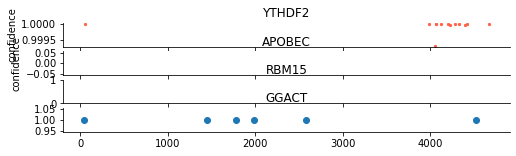

In [23]:
plot_edits('chr10:74838683|74843478')

# understand the distribution of significant edits per circle

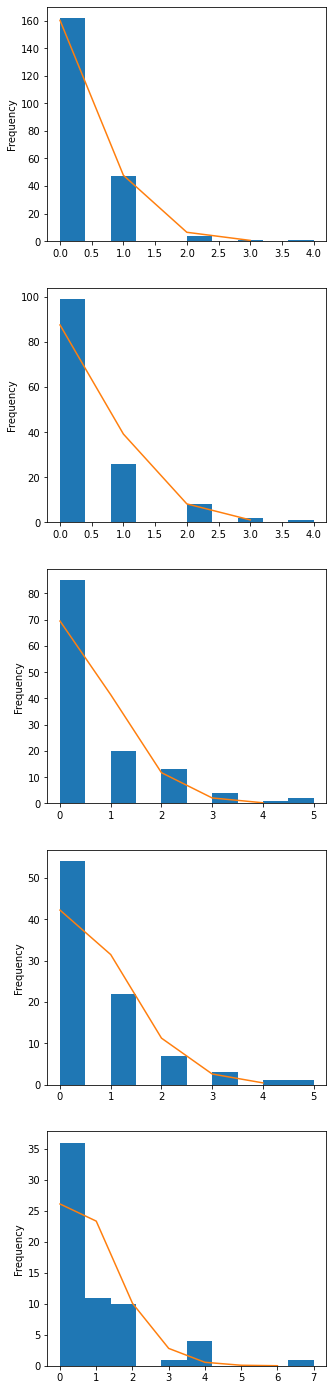

In [24]:
from scipy.stats import binom
cnt = cnts_per_circ['APOBEC1only']
rate = cnt.sum()[True]/cnt.sum().sum()

f, axes = plt.subplots(5,1, figsize = (5,25))
for n, ax in zip(range(10,50, 5), axes):
    data = cnt.loc[(cnt[False]+cnt[True])==n][True]
    data.plot.hist(ax = ax)

    ax.plot([binom.pmf(k=i, n=n, p=rate)*data.shape[0] for i in range(int(data.max()))])

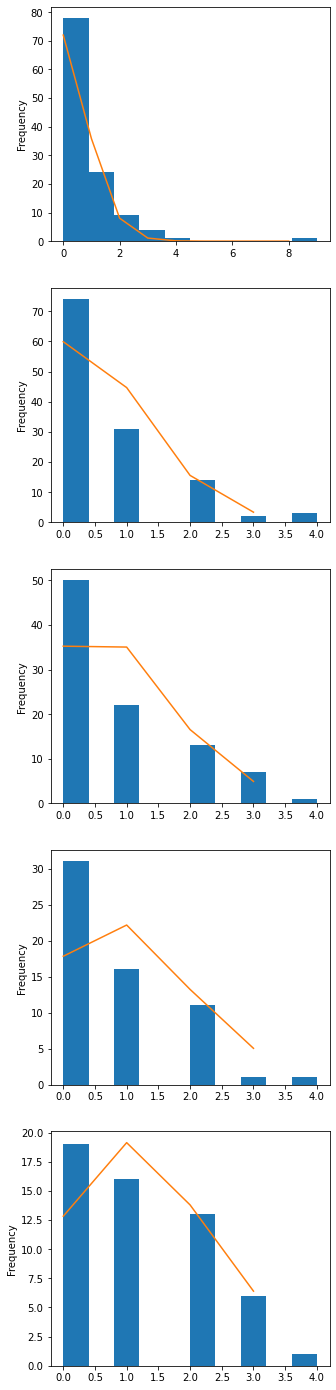

In [35]:
cnt = cnts_per_circ['YTHDF2_STAMP']
rate = cnt.sum()[True]/cnt.sum().sum()

f, axes = plt.subplots(5,1, figsize = (5,25))
for n, ax in zip(range(10,50, 5), axes):
    data = cnt.loc[(cnt[False]+cnt[True])==n][True]
    data.plot.hist(ax = ax)

    ax.plot([binom.pmf(k=i, n=n, p=rate)*data.shape[0] for i in range(int(data.max()))])

# windowing

In [26]:


for name in edits_filtered:
    edits_filtered[name]['type']=name
    

total = pd.concat(list(edits_filtered.values())).reset_index()
total['POS_bin'] = total['POS']//200
enrich_df = pd.pivot_table(total, index = ['circ_id', 'POS_bin'], columns = ['type'], values = ['is_enriched'],
               aggfunc = 'sum').fillna(0)
totalcnt_df = pd.pivot_table(total, index = ['circ_id', 'POS_bin'], columns = ['type'],
               aggfunc = 'size').fillna(0)

/scratch/hsher/33834097.tscc-mgr7.local/ipykernel_14529/2879472423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edits_filtered[name]['type']=name


In [46]:
annotation = pd.concat([
    total.groupby(by = ['circ_id','POS_bin'])['POS'].min(),
    total.groupby(by = ['circ_id','POS_bin'])['POS'].max(),
    
], axis = 1)
annotation.columns = ['start', 'end']

<AxesSubplot: >

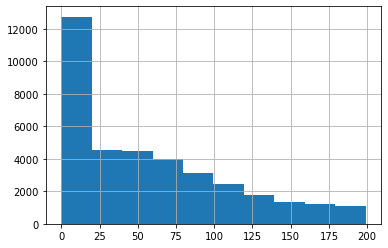

In [49]:
(annotation['end']-annotation['start']).hist()

<AxesSubplot: xlabel='APOBEC1only', ylabel='YTHDF2_STAMP'>

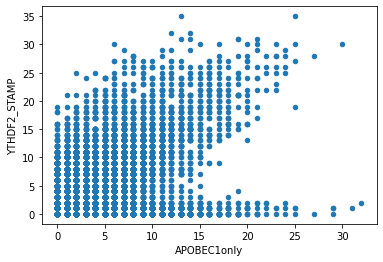

In [27]:
totalcnt_df.plot.scatter(x = 'APOBEC1only', y = 'YTHDF2_STAMP')

<AxesSubplot: xlabel='(is_enriched, APOBEC1only)', ylabel='(is_enriched, YTHDF2_STAMP)'>

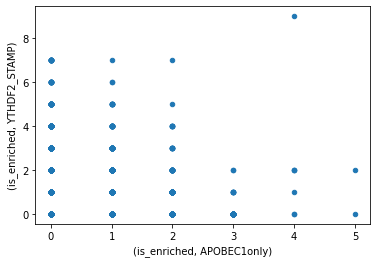

In [28]:
enrich_df.plot.scatter(x = ('is_enriched', 'APOBEC1only'), y = ('is_enriched', 'YTHDF2_STAMP'))

In [29]:
all_cnt = pd.concat([totalcnt_df, enrich_df], axis = 1)

In [30]:
all_cnt.columns = totalcnt_df.columns.tolist()+ [f'n_enriched_{i}' for i in totalcnt_df.columns.tolist()]

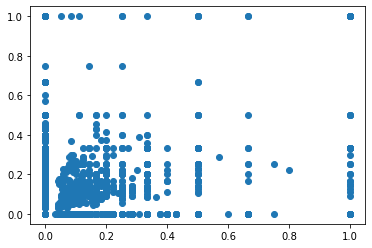

In [31]:
plt.scatter(x = all_cnt['n_enriched_APOBEC1only']/all_cnt['APOBEC1only'],
            y = all_cnt['n_enriched_YTHDF2_STAMP']/all_cnt['YTHDF2_STAMP']
           )

# correlate edit fraction at position

Text(0.5, 1.0, 'edit_fraction at each position')

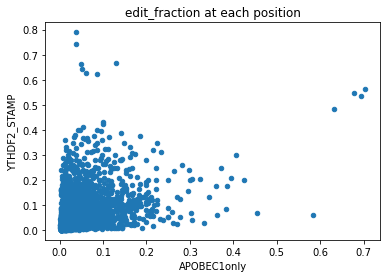

In [32]:
editfrac_df = pd.concat([edits_filtered[i].set_index('pos_id')['edit_frac'] for i in edits_filtered.keys()]
                        , axis = 1).dropna()
editfrac_df.columns = edits_filtered.keys()
editfrac_df.plot.scatter(x = 'APOBEC1only', y = 'YTHDF2_STAMP')
plt.title('edit_fraction at each position')

Text(0.5, 1.0, 'edit_fraction at each position')

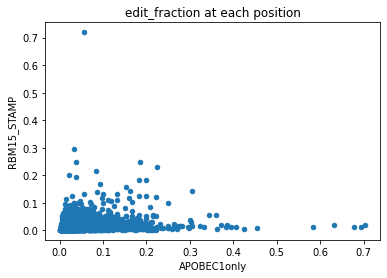

In [34]:
editfrac_df = pd.concat([edits_filtered[i].set_index('pos_id')['edit_frac'] for i in edits_filtered.keys()]
                        , axis = 1).dropna()
editfrac_df.columns = edits_filtered.keys()
editfrac_df.plot.scatter(x = 'APOBEC1only', y = 'RBM15_STAMP')
plt.title('edit_fraction at each position')

Text(0.5, 1.0, 'coverage at each position')

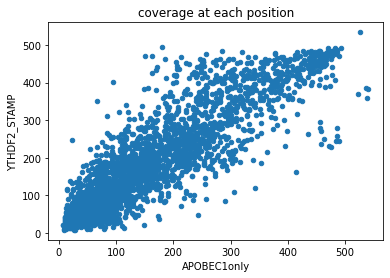

In [33]:
editfrac_df = pd.concat([edits_filtered[i].set_index('pos_id')['total'] for i in edits_filtered.keys()]
                        , axis = 1).dropna()
editfrac_df.columns = edits_filtered.keys()
editfrac_df.plot.scatter(x = 'APOBEC1only', y = 'YTHDF2_STAMP')
plt.title('coverage at each position')

# evaluate pos_bin

In [36]:
all_cnt

APOBEC1only  RBM15_STAMP  YTHDF2_STAMP  \
circ_id                   POS_bin                                           
chr10:100190869|100205199 0                2.0          0.0           0.0   
                          12               2.0          0.0           0.0   
                          18               0.0          1.0           0.0   
                          45               1.0          0.0           0.0   
                          49               3.0          0.0           0.0   
...                                        ...          ...           ...   
chrX:85046446|85074391    138              3.0          0.0           4.0   
                          139              4.0          0.0           8.0   
chrX:85067127|85074400    0                1.0          1.0           1.0   
                          34               0.0          0.0           3.0   
                          36               0.0          0.0           2.0   

                                   n_enriched_APOBEC1only  \
circ_id                   POS_bin                           
chr10:100190869|100205199 0                           1.0   
                          12                          0.0   
                          18                          0.0   
                          45                          0.0   
                          49                          0.0   
...                                                   ...   
chrX:85046446|85074391    138                         0.0   
                          139                         0.0   
chrX:85067127|85074400    0                           0.0   
                          34                          0.0   
                          36                          0.0   

                                   n_enriched_RBM15_STAMP  \
circ_id                   POS_bin                           
chr10:100190869|100205199 0                           0.0   
                          12                          0.0   
                          18                          0.0   
                          45                          0.0   
                          49                          0.0   
...                                                   ...   
chrX:85046446|85074391    138                         0.0   
                          139                         0.0   
chrX:85067127|85074400    0                           0.0   
                          34                          0.0   
                          36                          0.0   

                                   n_enriched_YTHDF2_STAMP  
circ_id                   POS_bin                           
chr10:100190869|100205199 0                            0.0  
                          12                           0.0  
                          18                           0.0  
                          45                           0.0  
                          49                           0.0  
...                                                    ...  
chrX:85046446|85074391    138                          0.0  
                          139                          0.0  
chrX:85067127|85074400    0                            0.0  
                          34                           0.0  
                          36                           0.0  

[36805 rows x 6 columns]

#